## Load Results After no_l1_p4

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('../data/maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [2]:
# Results based on latest epoch before ROC analysis

with open(f'../data/results/fam_finetune/predictions_esm2_t33_650M_UR50D/roc_results_roc.pkl', 'rb') as f:
    results = pickle.load(f)

### View sequences with bad family scores

Full sequence, top accuracy

In [3]:
score_full = []
coverage_full = [] # What % of sequence is hit region

for key in results.keys():
    preds = results[key]['psalm_f_indices'].ravel()
    target = results[key]['true_f'].ravel()

    score = (preds == target).sum() / preds.shape[0]
    coverage = (target != 19632).sum() / target.shape[0]

    score_full.append(score)
    coverage_full.append(coverage)

Hit region accuracy

In [4]:
score_hit = []
coverage_hit = [] # What % of sequence is hit region

for key in results.keys():
    preds = results[key]['psalm_f_indices'].ravel()
    target = results[key]['true_f'].ravel()

    idx = target != 19632
    score = (preds[idx] == target[idx]).sum() / preds[idx].shape[0]
    coverage = target[idx].shape[0] / target.shape[0]
    
    score_hit.append(score)
    coverage_hit.append(coverage)

Family wise accuracy (just unique ids)

In [5]:
score_doms = []
coverage_doms = [] # This coverage represents % length of this domain in whole seq
fam_doms  = []
length_doms = []

for key in results.keys():
    preds = results[key]['psalm_f_indices'].ravel()
    target = results[key]['true_f'].ravel()

    unique_fams = np.unique(target)
    unique_fams = np.delete(unique_fams, np.where(unique_fams == 19632))

    for fam in unique_fams:
        idx = target == fam
        score = (preds[idx] == target[idx]).sum() / preds[idx].shape[0]
        coverage = target[idx].shape[0] / target.shape[0]

        score_doms.append(score)
        coverage_doms.append(coverage)
        fam_doms.append(fam)
        length_doms.append(target[idx].shape[0])

### Visualizing Errors

Text(0.5, 1.0, 'Score vs. coverage: Family wise')

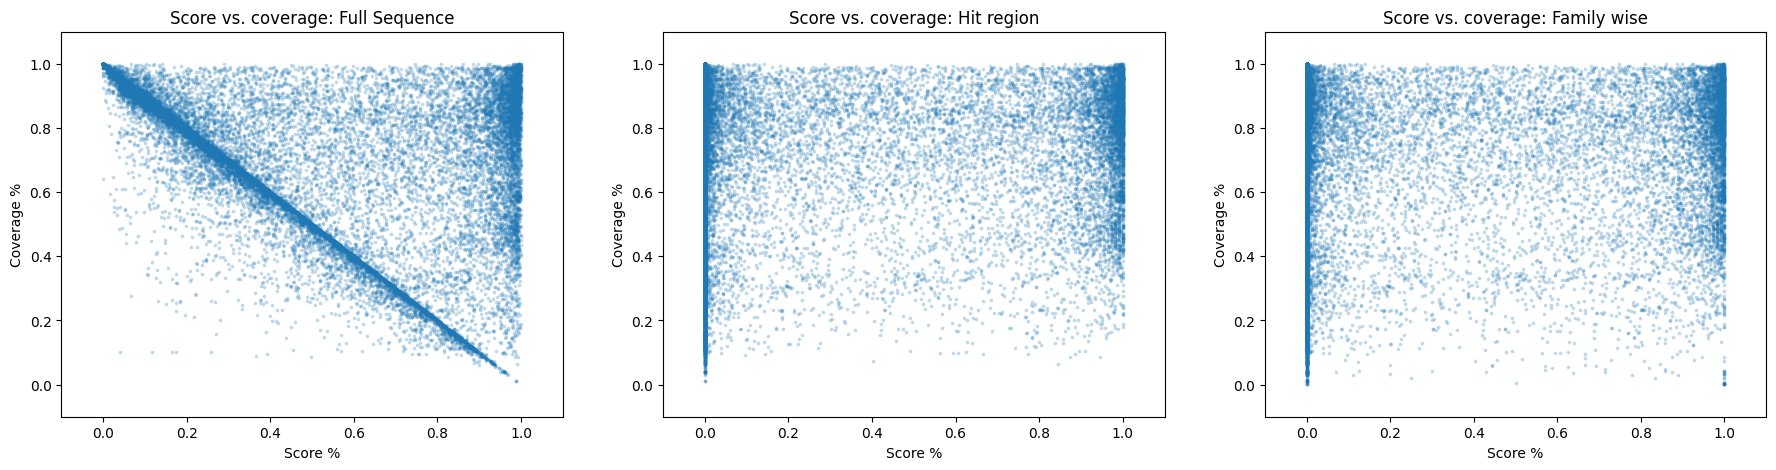

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))

ax1.scatter(score_full, coverage_full, s=3, alpha=0.2)
ax2.scatter(score_hit, coverage_hit, s=3, alpha=0.2)
ax3.scatter(score_doms, coverage_doms, s=3, alpha=0.2)


ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel('Score %')
ax1.set_ylabel('Coverage %')
ax1.set_title('Score vs. coverage: Full Sequence')

ax2.set_xlim(-0.1,1.1)
ax2.set_ylim(-0.1,1.1)
ax2.set_xlabel('Score %')
ax2.set_ylabel('Coverage %')
ax2.set_title('Score vs. coverage: Hit region')

ax3.set_xlim(-0.1,1.1)
ax3.set_ylim(-0.1,1.1)
ax3.set_xlabel('Score %')
ax3.set_ylabel('Coverage %')
ax3.set_title('Score vs. coverage: Family wise')

### Train examples seen by family

In [59]:
# Map between fam idx and examples seen

from collections import defaultdict
from tqdm import tqdm

all_examples = defaultdict(int)

# Go through each shard

for shard in tqdm(range(1, 51), total = 50, desc='Processing'):

    # Load train example count file
    with open(f'../data/train_examples_shardwise/train_examples_{shard}.pkl', 'rb') as f:
        examples = pickle.load(f)
        examples = examples['counts']

        # Add the counts in this file for examples seen for each family to existing counts
        for key in examples:
            all_examples[key] += examples[key]

# Save aggregate result
with open(f'../data/train_example_count.pkl', 'wb') as f:
    pickle.dump({'counts': all_examples}, f)

Processing: 100%|██████████| 50/50 [00:00<00:00, 95.91it/s] 


### Domain wise accuracy

In [7]:
with open(f'../data/train_example_count.pkl', 'rb') as f:
    counts = pickle.load(f)
    counts = counts['counts']

num_fams = 19632
score_dom_avg = np.zeros(num_fams)
score_dom_std = np.zeros(num_fams)
length_dom_avg = np.zeros(num_fams)
length_dom_std = np.zeros(num_fams)

sanity_scores = []

# Go through all family indices
for fam_idx in range(num_fams):

    # Which domain result indices correspond to this family
    positions = np.array(fam_doms) == fam_idx

    # Find score and length for these domain indices
    scores = np.array(score_doms)[positions]
    lengths = np.array(length_doms)[positions]

    # If there were no domains then continue
    if scores.shape[0] == 0:
        continue
    
    # Compute mean and std for the score and length of this family
    score_dom_avg[fam_idx] = scores.mean()
    score_dom_std[fam_idx] = scores.std()
    length_dom_avg[fam_idx] = lengths.mean()
    length_dom_std[fam_idx] = lengths.std()
    sanity_scores.append(scores.mean())

In [8]:
example_count = np.array([counts[key] for key in range(num_fams)])

### Map from examples seen to list of fam indices (get ID through idx_fam map)

In [ ]:
from collections import defaultdict
count_fam_list = {}

for i in range(max(example_count)): # Currently 3502 is max count
    count_fam_list[i] = np.where(example_count == i)[0]

In [67]:
print(np.mean(sanity_scores))

filter_indices = np.unique(fam_doms)
print(score_dom_avg[filter_indices].mean())

0.3448415504770664
0.3448415504770664


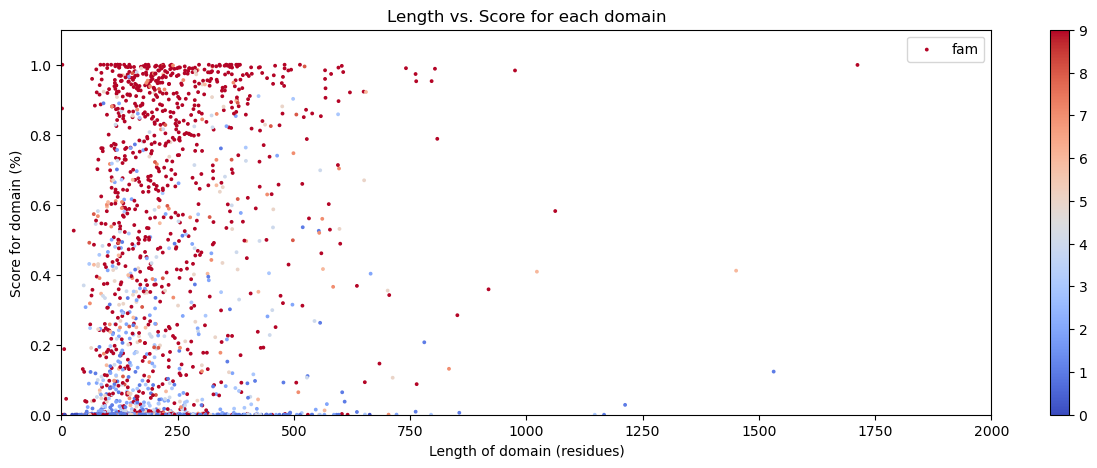

In [68]:
f, ax = plt.subplots(figsize=(15,5))

#ax.errorbar(length_dom_avg, score_dom_avg, xerr=length_dom_std+1e-4, yerr=score_dom_std+1e-4, linestyle='none', marker='o', capsize=1.0, ecolor='black', c=example_count, markersize=3, vmin=0, vmax=4000)
#ax.errorbar(length_dom_avg, score_dom_avg, xerr=length_dom_std, yerr=score_dom_std, linestyle='none', marker='o', markersize=2, elinewidth=0.5, capsize=1.0, ecolor='black', label='fam')
color_bar = ax.scatter(length_dom_avg[filter_indices], score_dom_avg[filter_indices], c=example_count[filter_indices], cmap='coolwarm', vmin=0, vmax=9,  s=3, label='fam')
ax.set_xlabel('Length of domain (residues)')
ax.set_ylabel('Score for domain (%)')
ax.set_title('Length vs. Score for each domain')
ax.set_xlim(0,2000)
ax.set_ylim(0,1.1)
ax.legend()
plt.colorbar(color_bar, ax=ax)

### Distribution of #Examples seen in train

Filtered all domains that are not part of train (did not satisfy initial 25% pid criteria, so stayed thrown out even after sfetch possibly). ~8k domains not seen. All domains > 9 examples grouped in last bin

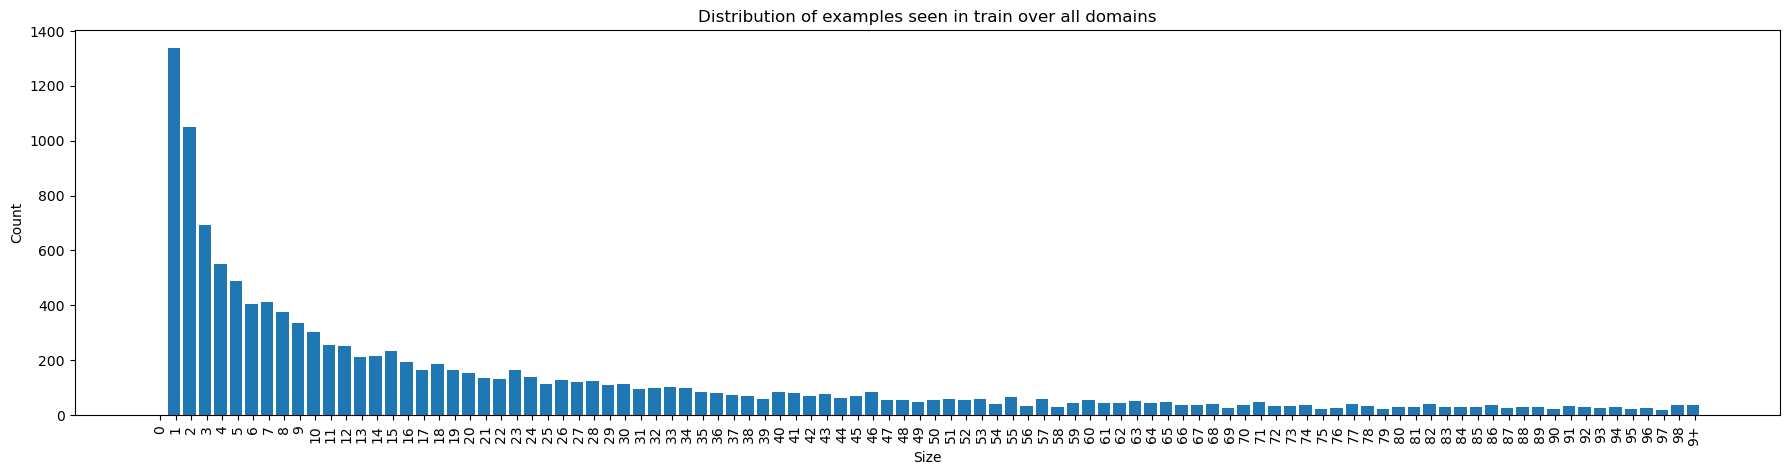

In [83]:
f, ax = plt.subplots(figsize=(22,5))

vals = 100
bins = 100

filtered_example_count = example_count[example_count > 0]

edges = ax.hist(filtered_example_count, bins=bins, range=(0,vals), align='left', width=0.8)


ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Distribution of examples seen in train over all domains')

labels = [str(i) for i in range(0, vals, int(vals/bins))]
labels[-1] = '9+'
ticks = [i for i in range(0, vals, int(vals/bins))]
ax.set_xticks(ticks, labels, rotation=90)
plt.show()


In [72]:
np.sum(edges[0])

5946.0

### Score distribution by number of examples seen in train

Text(0.5, 1.0, 'Score variation with number of seen examples in training')

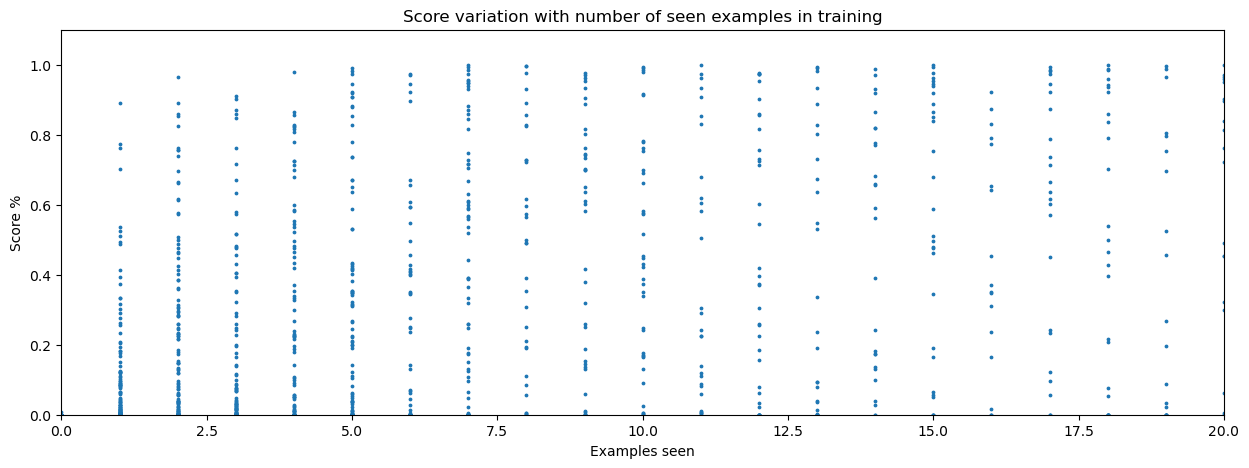

In [73]:
f, ax = plt.subplots(figsize=(15,5))

ax.scatter(example_count[filter_indices], score_dom_avg[filter_indices], s=3)
ax.set_xlabel('Examples seen')
ax.set_ylabel('Score %')
ax.set_ylim(0,1.1)
ax.set_xlim(0,20)
ax.set_title('Score variation with number of seen examples in training')

In [79]:
np.sum(example_count[filter_indices]==1)

332

In [87]:
for i in range(1, 50):
    idx = example_count[filter_indices] == i

    avg = np.mean(score_dom_avg[filter_indices][idx])
    print(i, avg)

1 0.04184380510216236
2 0.14274908286863378
3 0.1508049042947702
4 0.22663708787429668
5 0.29857271263941165
6 0.26689429420184385
7 0.4178169569716015
8 0.44195146564955545
9 0.4705876670654504
10 0.43373099985758573
11 0.39181952650186486
12 0.4079665537184338
13 0.3675871795466884
14 0.4845552536138013
15 0.5480045685844794
16 0.42990276827456797
17 0.5499934723192236
18 0.45723430979921487
19 0.36123835988133435
20 0.5935105172686556
21 0.4804049486772644
22 0.47792426890951994
23 0.5050044018779916
24 0.5773136367664072
25 0.5704722645351998
26 0.6609977152884592
27 0.5197411947385333
28 0.5175378404191382
29 0.6656984883478871
30 0.5857521453909509
31 0.37040046479902655
32 0.6240895103725184
33 0.649603389660668
34 0.5331709326083467
35 0.42089612866996257
36 0.6535009184054967
37 0.6683335164324838
38 0.2885997706524258
39 0.6694541005335364
40 0.47026227165381435
41 0.49695230757901054
42 0.7647020238439808
43 0.5964232615260542
44 0.8120873633540278
45 0.46387745646697803
46 

Text(0.5, 1.0, 'Examples seen vs. Avg. Score')

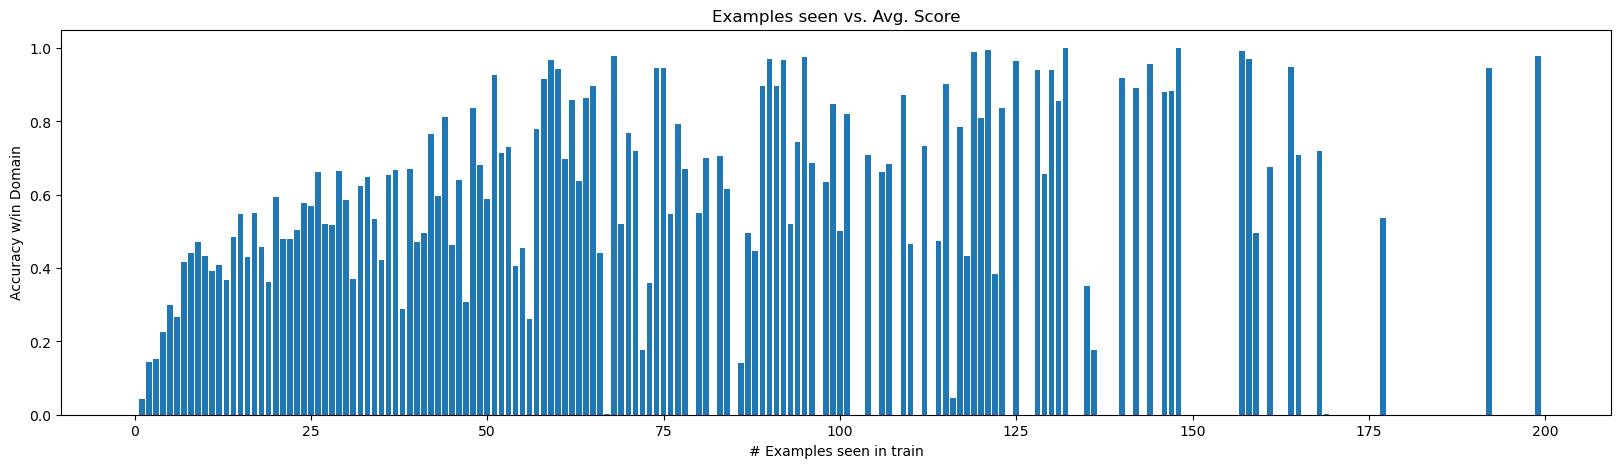

In [76]:
total = 200
seen_seqs = np.zeros(total)
seen_scores = np.zeros(total)

for i in range(1, 200):
    idx = example_count[filter_indices] == i

    avg = np.mean(score_dom_avg[filter_indices][idx])
    seen_seqs[i] = idx.sum()
    seen_scores[i] = avg
# seen_scores = seen_scores.cumsum()

f, ax = plt.subplots(figsize=(20,5))

import matplotlib as mpl
my_cmap = mpl.colormaps['coolwarm']
# score_color = seen_scores
# score_color[np.isnan(score_color)] = 0.5
colors = my_cmap(seen_scores)

cb = ax.bar(range(total), seen_scores)
ax.set_xlabel('# Examples seen in train')
ax.set_ylabel('Accuracy w/in Domain')
# ax.set_yscale('log')
ax.set_title('Examples seen vs. Avg. Score')
